In [341]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import yfinance as yf
import datetime

In [2]:
%matplotlib inline

In [3]:
# Plot Style
plt.rcParams.update({'font.size': 15})

# Step 1: Data Pre-processing

## Download Data

In [320]:
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2007, 8,15)

data_PEP = yf.download('PEP', start , end)
data_KO = yf.download('KO', start , end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Reorganizing Data

In [321]:
data_PEP=data_PEP.reset_index()
data_PEP = data_PEP[['Date','Close']]
data_PEP.columns = ['Date','PEP']

data_KO =data_KO.reset_index()
data_KO = data_KO[['Date','Close']]
data_KO.columns = ['Date','KO']
data = pd.merge(data_PEP, data_KO, on='Date')

In [322]:
data.head()

,Date,PEP,KO
0,2006-01-03,59.759998,20.450001
1,2006-01-04,59.730000,20.410000
2,2006-01-05,59.380001,20.510000
3,2006-01-06,59.599998,20.705000
4,2006-01-09,59.299999,20.805000


## Data Visualization

### Data Visualization 1: Price Movements

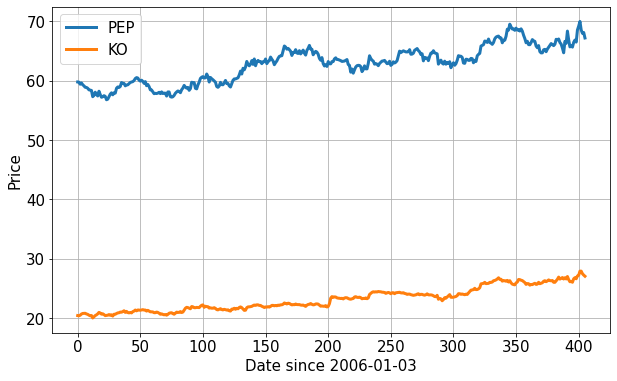

In [323]:
plt.figure(figsize=(10,6))
plt.plot(data['PEP'],linewidth=3,label='PEP')
plt.plot(data['KO'],linewidth=3,label='KO')
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Date since ' + str(data['Date'][0])[:10])
plt.ylabel('Price')
plt.legend()

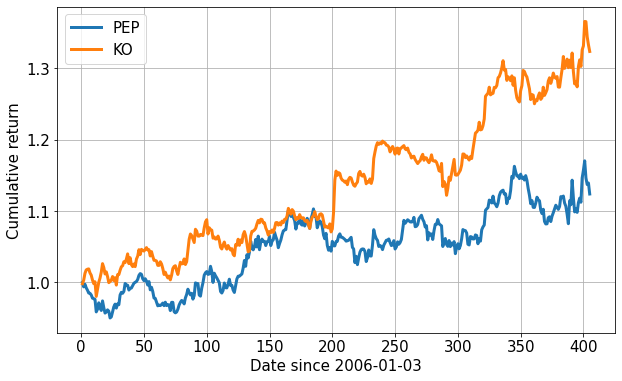

In [324]:
plt.figure(figsize=(10,6))
plt.plot((data['PEP'].pct_change()+1).cumprod(),linewidth=3,label='PEP')
plt.plot((data['KO'].pct_change()+1).cumprod(),linewidth=3,label='KO')
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.xlabel('Date since ' + str(data['Date'][0])[:10])
plt.ylabel('Cumulative return')
plt.legend()

### Visualization 2: Price Relationship Between the Two Securities


In [325]:
tickers = ['PEP', 'KO']


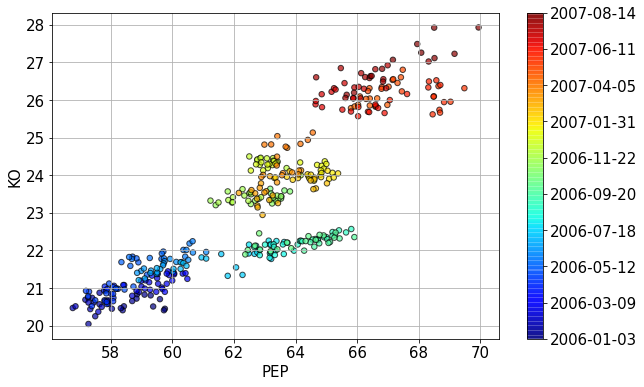

In [326]:
plt.figure(figsize=(10,6))
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(data['Date'][p])[:10] for p in data[::len(data)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1])
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')

# Step 2: OLS Linear Regression

In [327]:
x = sm.add_constant(data[tickers[0]], prepend=False)
ols = sm.OLS(data[tickers[1]], x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [328]:
print(ols.summary2())


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.762    
Dependent Variable: KO               AIC:                1124.3527
Date:               2021-09-05 11:06 BIC:                1132.3654
No. Observations:   406              Log-Likelihood:     -560.18  
Df Model:           1                F-statistic:        1297.    
Df Residuals:       404              Prob (F-statistic): 3.59e-128
R-squared:          0.762            Scale:              0.92918  
--------------------------------------------------------------------
         Coef.     Std.Err.      t       P>|t|     [0.025     0.975]
--------------------------------------------------------------------
PEP       0.5558     0.0154    36.0108   0.0000     0.5255    0.5861
const   -11.6810     0.9699   -12.0432   0.0000   -13.5877   -9.7743
------------------------------------------------------------------
Omnibus:               22.327       Durbin-Watson:          0.059 
Pro

In [329]:
 ols.params[0]

0.555791348929677

In [330]:
beta = ols.params

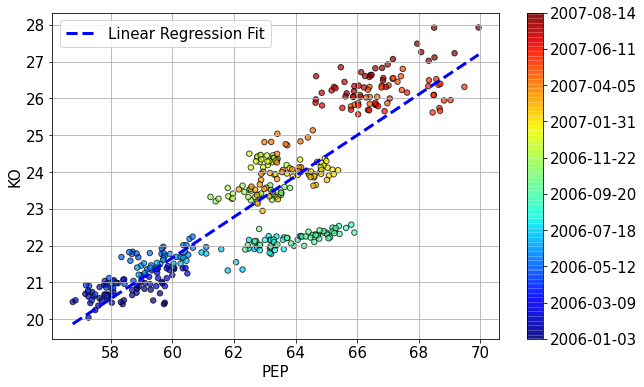

In [331]:
plt.figure(figsize=(10,6))
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='Linear Regression Fit')
plt.legend()

cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(data['Date'][p])[:10] for p in data[::len(data)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1])
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')

#### Conclusion: It is a perfect fit because this is in-sample or using the train datasets

# Step 3: Modelling the Spread

In [332]:
spread = pd.DataFrame(data[tickers[1]] - beta[0] * data[tickers[0]] - beta[1])
spread.columns = ['in-sample']

Text(0.5, 1.0, 'PEP- KO Spread')

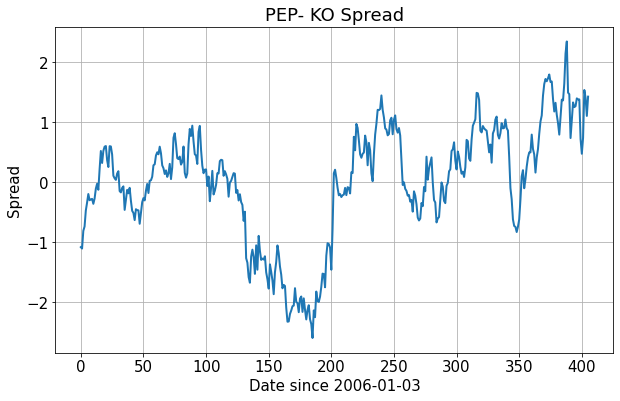

In [333]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')

plt.plot(spread,linewidth=2)
plt.xlabel('Date since ' + str(data['Date'][0])[:10])
plt.ylabel('Spread')
plt.title('PEP- KO Spread')

# Step 4: Let's  Design Trade Strategy!

Text(0.5, 0, 'Date since 2006-01-03')

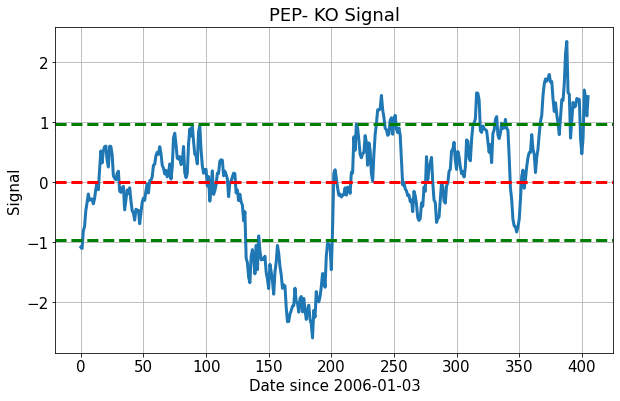

In [340]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')

plt.plot(spread,linewidth=3)
plt.axhline(spread['in-sample'].mean(), ls = '--', color='r',linewidth=3)
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='g',linewidth=3)
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='g',linewidth=3)
plt.ylabel('Signal')
plt.title('PEP- KO Signal')
plt.xlabel('Date since ' + str(data['Date'][0])[:10])



Mean-reverting Trading Strategy:

(1) short when the signal hits level (mean+std) and clean the position (i.e., buy back) when it falls back to 0

(2) long when the signal hits level -(mean+std) and clean the position (i.e., sell all) when it rises up to 0

Each sucessful trade makes a profit of 1 dollar!

# Step 5: Test Trade Strategy (Out of Sample)

In [335]:
start_oos = datetime.datetime(2007, 8, 15)
end_oos = datetime.datetime(2007, 12,31)

data_PEP_oos = yf.download('PEP', start_oos , end_oos)
data_KO_oos = yf.download('KO', start_oos , end_oos)

data_PEP_oos = data_PEP_oos.reset_index()
data_PEP_oos = data_PEP_oos[['Date','Close']]
data_PEP_oos.columns = ['Date','PEP']

data_KO_oos =data_KO_oos.reset_index()
data_KO_oos = data_KO_oos[['Date','Close']]
data_KO_oos.columns = ['Date','KO']
data_oos = pd.merge(data_PEP_oos, data_KO_oos, on='Date')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [336]:
spread_oos = data_oos[tickers[1]] - beta[0] * data_oos[tickers[0]] - beta[1]


In [337]:
spread_oos_index = len(spread) +np.cumsum(np.ones(spread_oos.shape[0]))-1

Text(0.5, 0, 'Date since 2006-01-03')

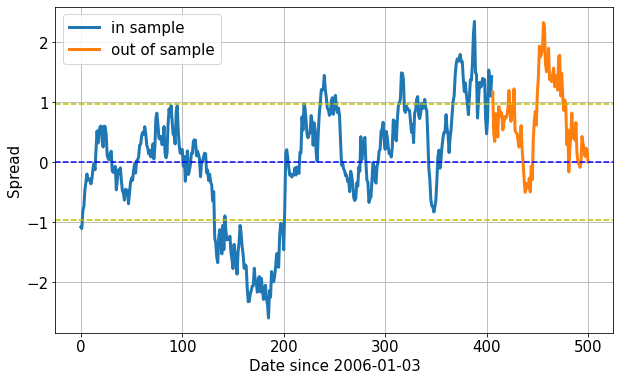

In [338]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.grid(which='minor', linestyle=':', linewidth='0.5')

plt.plot(spread,linewidth=3,label='in sample')
plt.plot(spread_oos_index, spread_oos,label='out of sample',linewidth=3)
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='y');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='y');
plt.legend()
plt.ylabel('Spread')
plt.xlabel('Date since ' + str(data['Date'][0])[:10])
